In [ ]:
import sys
import importlib
sys.path.append("/users/jmduchar/data/jmduchar/Research/mcgill25/rfi_characterization/")
import python.utils as ut

import os
import numpy as np
import arviz as az
from numpy.polynomial.legendre import legvander
import matplotlib.pyplot as plt
from cmdstanpy import CmdStanModel
import json
import glob
from scipy.stats import norm, cauchy, mode, t
from cmdstanpy import from_csv
import seaborn as sns
from tqdm import tqdm
import corner

plt.style.use('seaborn-v0_8')

In [2]:
outputs = glob.glob("../stan/stan_out/legendre-20251025195338_*.csv")

fit = from_csv(outputs)

13:34:01 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1000 iterations at max treedepth (100.0%)
	Chain 2 had 1000 iterations at max treedepth (100.0%)
	Chain 3 had 1 divergent transitions (0.1%)
	Chain 3 had 999 iterations at max treedepth (99.9%)
	Chain 4 had 1000 iterations at max treedepth (100.0%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


In [3]:
print(fit.diagnose())

Checking sampler transitions treedepth.
3999 of 1000 (399.90%) transitions hit the maximum treedepth limit of 10, or 2^10 leapfrog steps.
Trajectories that are prematurely terminated due to this limit will result in slow exploration.
For optimal performance, increase this limit.

Checking sampler transitions for divergences.
1 of 1000 (0.10%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
The E-BFMI, 0.00, is below the nominal threshold of 0.30 which suggests that HMC may have trouble exploring the target distribution.
If possible, try to reparameterize the model.

Rank-normalized split effective sample size satisfactory for all parameters.

The following parameters had rank-normalized split R-hat greater than 1.01:
  theta

In [5]:
# Load JSON data

with open(
    "/users/jmduchar/data/jmduchar/Research/mcgill25/rfi_characterization/data/json/legendre_semisupervised_p0.json",
    "r"
) as f:
    data_dict = json.load(f)

In [6]:
# Convert to arviz inference data object
importlib.reload(ut)

idata = ut.build_idata(data_dict, fit)

/users/jmduchar/data/jmduchar/Research/mcgill25/rfi_characterization/python/utils.py:270: SyntaxWarning: invalid escape sequence '\s'
  lw=2, label=f"Empirical N(0, $\sigma$ = {empirical_std:.2f})",


KeyError: 'mu_X'

In [7]:
# az.summary(idata, var_names=["rate_rising","rate_decay","mu_blip","log_k_blip","X"])
az.plot_trace(
    idata,
    var_names=["rate_rising", "rate_decay", "mu_blip", "log_k_blip"],
    compact=False,
    combined=False,
)
plt.tight_layout(pad=1.0)
plt.show()

NameError: name 'idata' is not defined

In [8]:
ut.plot_supervised_inputs(data_dict)

TypeError: plot_supervised_inputs() missing 1 required positional argument: 'pointing'

In [9]:
importlib.reload(ut)

for i in range(50):
    ut.plot_data_vs_pred(data_dict, fit, pointing='p0', 
            cut_idx=i,
            save_path=None,
    )

KeyError: 'start_stop_idx'

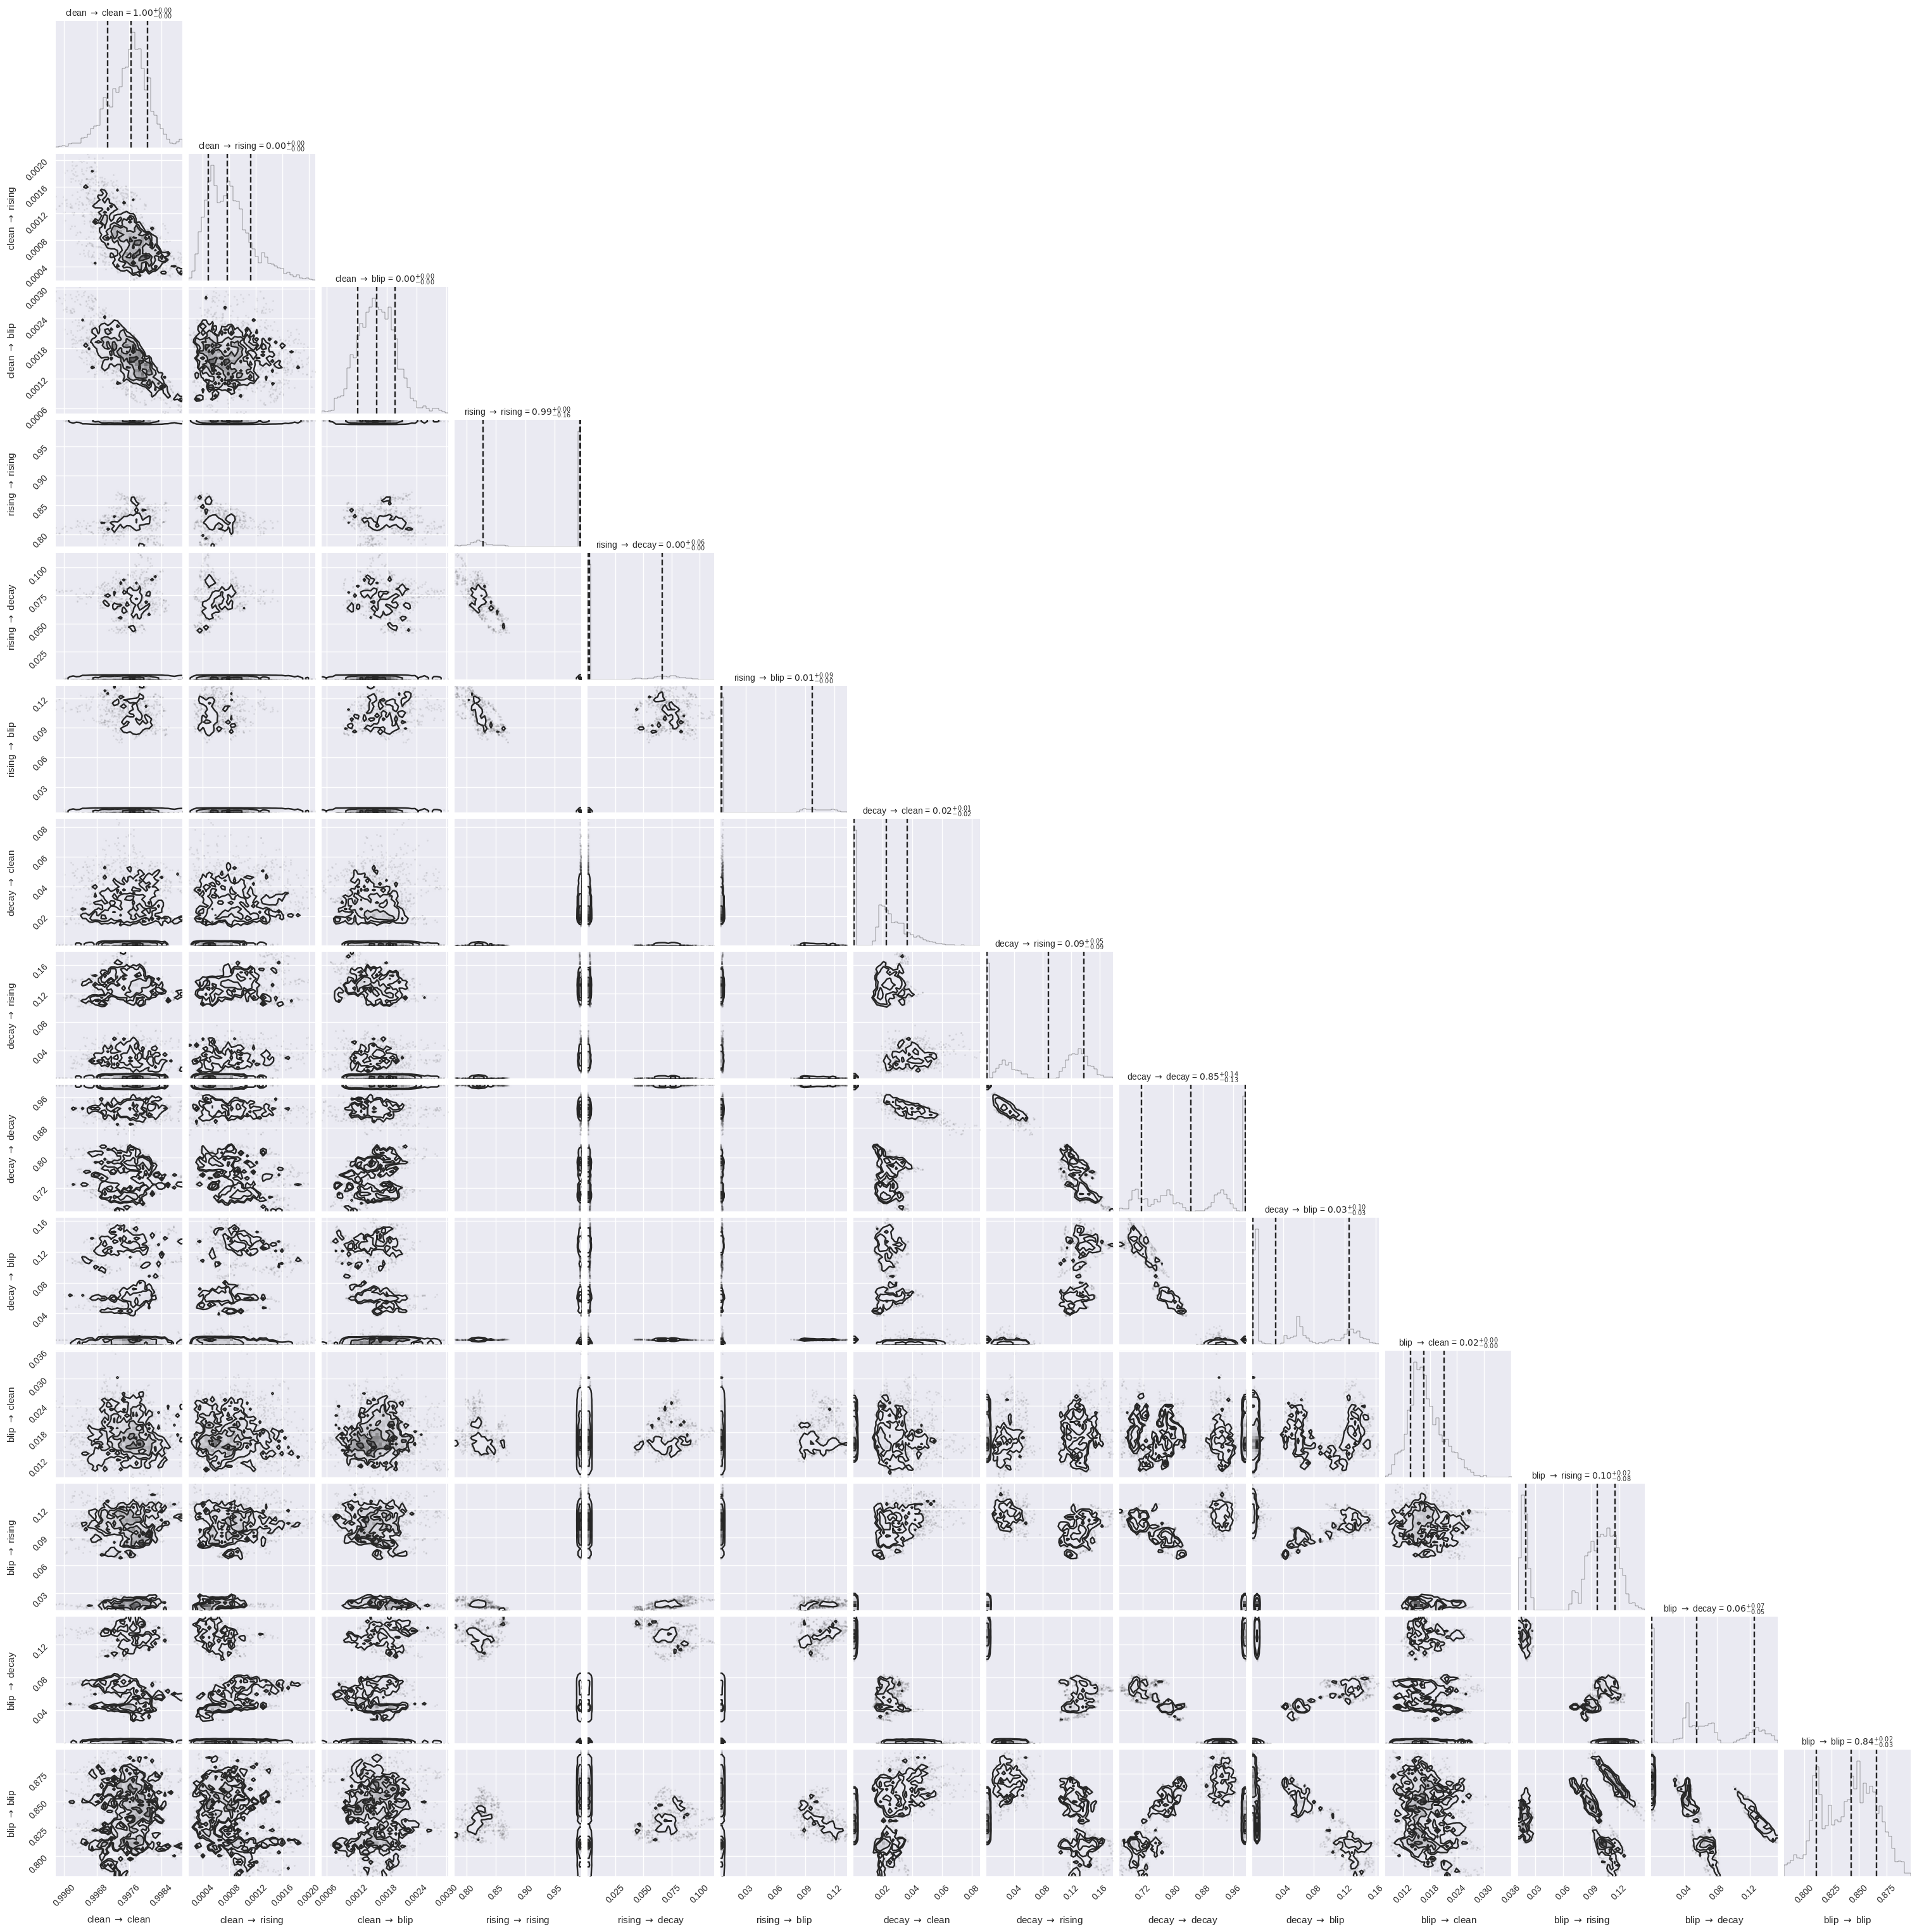

In [10]:
importlib.reload(ut)

ut.transition_corner_plot(fit, save_path=None)

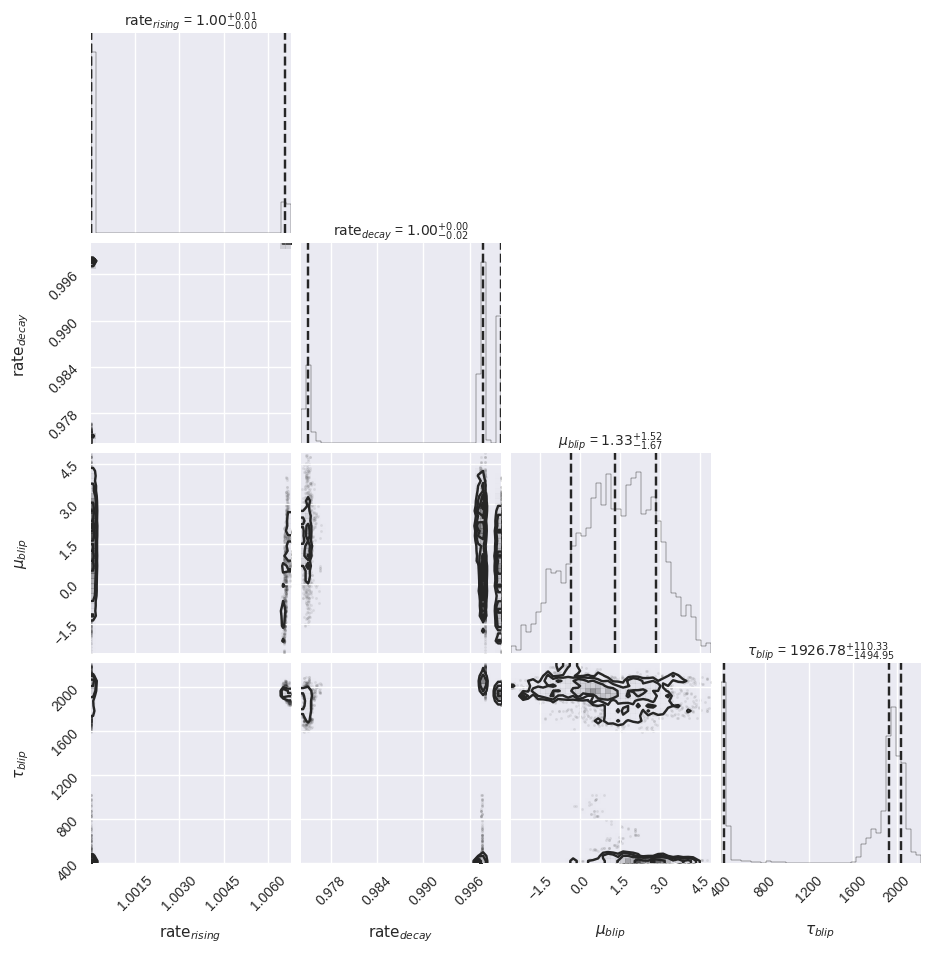

In [11]:
importlib.reload(ut)

ut.emission_corner_plot(fit, save_path=None)

/users/jmduchar/.conda/envs/stan/lib/python3.13/site-packages/numpy/lib/_histograms_impl.py:901: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/users/jmduchar/.conda/envs/stan/lib/python3.13/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/users/jmduchar/.conda/envs/stan/lib/python3.13/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/users/jmduchar/.conda/envs/stan/lib/python3.13/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


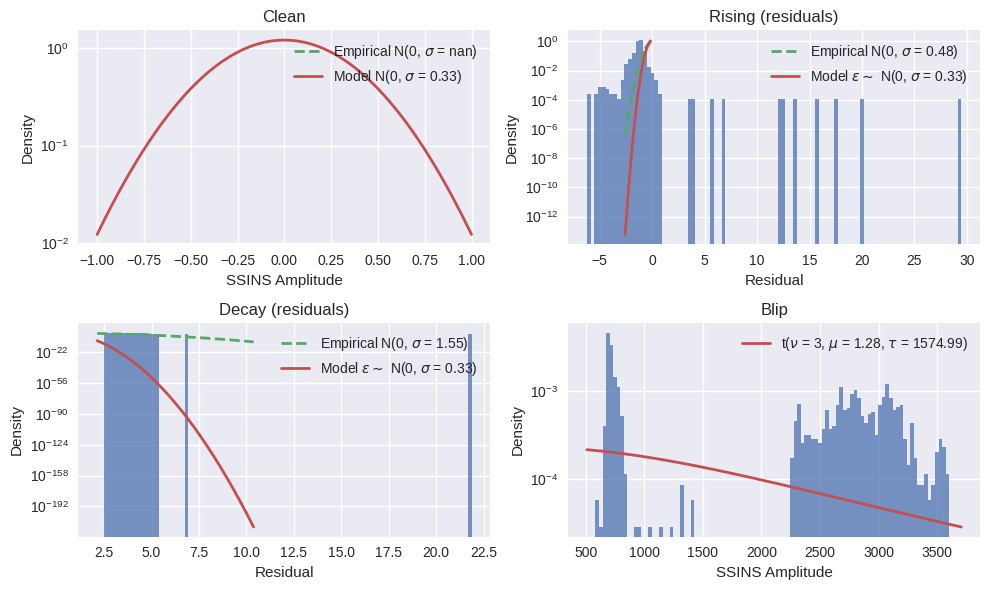

In [12]:
importlib.reload(ut)

ut.plot_prediction_hist(data_dict, fit, save_path=None)

In [13]:
X = fit.stan_variables()['X']      # (4000, 8)
X_mode = mode(X, axis=0).mode

KeyError: 'X'

In [ ]:
design_matrix = np.asarray(data_dict['A_unsup'])

design_matrix.shape

In [ ]:
X = fit.stan_variables()['X']            # (draws, L)
A = np.asarray(data_dict['A_unsup'])     # (N, L)
y = np.asarray(data_dict['y_unsup'])     # (N,)

mu_draws = X @ A.T                        # (draws, N)
mu_mean  = mu_draws.mean(axis=0)

plt.figure(figsize=(9, 3))
plt.scatter(np.arange(len(y)), y, s=1, label='Input data', alpha=0.75)
plt.plot(mu_mean, lw=2, label='Background (Legendre Polynomial)', color=sns.color_palette()[2])
plt.legend()
plt.tight_layout()
plt.ylim(-10,10)
plt.xlim(100,500)
plt.show()